In [1]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptun_token = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptun_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import io
import math
import json
import neptune
import tensorflow as tf

import cirq
import numpy as np
from qsgenerator.utils import map_to_radians
from qsgenerator.qugans import circuits
from qsgenerator.resolvers import resolve_all
from qsgenerator.qugans.training import Trainer
from qsgenerator.phase.circuits import build_ground_state_circuit
from qsgenerator.phase.constants import z1_theta, z2_theta
from qsgenerator.phase.analitical import  get_ground_state_for_g
from qsgenerator.states.simple_state_circuits import build_x_rotation_state
from qsgenerator.states.simple_rotation_generators import get_binary_x_rotation_provider, get_arcsin_x_rotation_provider
from qsgenerator.phase.analitical import construct_hamiltonian, get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator

In [41]:
use_neptune = False

In [42]:
generator_layers = 5
discriminator_layers = 5
data_bus_size = 5

In [43]:
real_phase = True
generic_generator = False
all_layers_labeling = False
full_layer_labeling = False
use_gen_label_qubit = False
use_disc_label_qubit = False
zxz = False
fixed_gates = {}

In [44]:
gen, gs, disc, ds, ls, data_qubits, out_qubit = circuits.build_gan_circuits(
    generator_layers, 
    discriminator_layers, 
    data_bus_size, 
    all_layers_labeling=all_layers_labeling,
    full_layer_labeling=full_layer_labeling,
    use_gen_label_qubit=use_gen_label_qubit,
    use_disc_label_qubit=use_disc_label_qubit)

In [45]:
if not generic_generator:
    gen, gs, symbols_dict_gen = build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)
else:
    symbols_dict_gen = {}

In [46]:
gen, gs = resolve_all(gen, gs, symbols_dict_gen, fixed_gates)

In [47]:
if real_phase:
    real, real_symbols, symbols_dict_real = build_ground_state_circuit(qubits=data_qubits)
else:
    real, real_symbols, symbols_dict_real = build_x_rotation_state(qubits=data_qubits)

In [48]:
pure_gen = gen.copy()
gen.append([disc])

In [49]:
pure_real = real.copy()
real.append([disc])

In [50]:
print("REAL GROUND STATE")
pure_real

REAL GROUND STATE


(0, 1): ───H───@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │
(0, 2): ───────X───Z───Ry(theta_r)───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                   │                                       │
(0, 3): ─────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                   │                                       │
(0, 4): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                   │                                       │
(0, 5): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───

In [51]:
print("GENERATOR")
pure_gen

GENERATOR


(0, 1): ───H───@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │
(0, 2): ───────X───Z───Ry(theta0)───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                 │                                     │
(0, 3): ────────────────────────────Ry(theta3)───X───X───Ry(theta4)───X───Ry(theta1)───X───X───Ry(theta2)───X───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                             │                                     │
(0, 4): ────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta7)───X───X───Ry(theta8)───X───Ry(theta5)───X───X───Ry(theta6)───X───X─────────────@───X──────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                          │                                      │
(0, 5): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta11)───X───X───Ry(theta12)───X───Ry(theta9)───X───X───Ry(theta10)───X───

In [52]:
print("DISCRIMINATOR")
disc

DISCRIMINATOR


(0, 0): ───Rx(d0)───Rz(d6)────ZZ────────────────Rx(d17)───Rz(d23)───ZZ────────────────Rx(d34)───Rz(d40)───ZZ────────────────Rx(d51)───Rz(d57)───ZZ────────────────Rx(d68)───Rz(d74)───ZZ────────────────
                              │                                     │                                     │                                     │                                     │
(0, 1): ───Rx(d1)───Rz(d7)────ZZ^d12───ZZ───────Rx(d18)───Rz(d24)───ZZ^d29───ZZ───────Rx(d35)───Rz(d41)───ZZ^d46───ZZ───────Rx(d52)───Rz(d58)───ZZ^d63───ZZ───────Rx(d69)───Rz(d75)───ZZ^d80───ZZ───────
                                       │                                     │                                     │                                     │                                     │
(0, 2): ───Rx(d2)───Rz(d8)────ZZ───────ZZ^d15───Rx(d19)───Rz(d25)───ZZ───────ZZ^d32───Rx(d36)───Rz(d42)───ZZ───────ZZ^d49───Rx(d53)───Rz(d59)───ZZ───────ZZ^d66───Rx(d70)───Rz(d76)───ZZ───────ZZ^d83───
                              │                                     │                                     │                                     │                                     │
(0, 3): ───Rx(d3)───Rz(d9)────ZZ^d13───ZZ───────Rx(d20)───Rz(d26)───ZZ^d30───ZZ───────Rx(d37)───Rz(d43)───ZZ^d47───ZZ───────Rx(d54)───Rz(d60)───ZZ^d64───ZZ───────Rx(d71)───Rz(d77)───ZZ^d81───ZZ───────
                                       │                                     │                                     │                                     │                                     │
(0, 4): ───Rx(d4)───Rz(d10)───ZZ───────ZZ^d16───Rx(d21)───Rz(d27)───ZZ───────ZZ^d33───Rx(d38)───Rz(d44)───ZZ───────ZZ^d50───Rx(d55)───Rz(d61)───ZZ───────ZZ^d67───Rx(d72)───Rz(d78)───ZZ───────ZZ^d84───
                              │                                     │                                     │                                     │                                     │
(0, 5): ───Rx(d5)───Rz(d11)───ZZ^d14────────────Rx(d22)───Rz(d28)───ZZ^d31────────────Rx(d39)───Rz(d45)───ZZ^d48────────────Rx(d56)───Rz(d62)───ZZ^d65────────────Rx(d73)───Rz(d79)───ZZ^d82────────────

In [53]:
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([0] * len(gs)) + \
                   np.random.normal(scale=eps, size=(len(gs),))
init_disc_weights = np.random.normal(size=(len(ds),))

gen_weights = tf.Variable(init_gen_weights, dtype=tf.float32)
disc_weights = tf.Variable(init_disc_weights, dtype=tf.float32)

In [54]:
class CustomScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps=4000):
        super(CustomScheduler, self).__init__()
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        return max(math.e ** - ((step+200) / (self.warmup_steps / math.log(100))), 0.01)

In [55]:
learning_rate = CustomScheduler()

opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [56]:
#g_values = [0.1, 0.4, 0.25]
g_values = [-0.5]
# x_rotations = get_binary_x_rotation_provider({0: '100', 1: '011', 2: '101'})
# real_values_provider = get_arcsin_x_rotation_provider(g_values, data_bus_size)
real_values_provider = get_g_parameters_provider()

In [66]:
epochs = 4
disc_iteration = 1
gen_iteration = 1

In [67]:
if use_neptune:
    neptune.init(project_qualified_name='wiktor.jurasz/thesis', api_token=neptun_token)
    neptun_params = {
        'generator_layers': generator_layers,
        'discriminator_layers': discriminator_layers,
        'g_values': g_values,
        'size':  data_bus_size,
        'real_phase': real_phase,
        'generic_generator': generic_generator,
        'all_layers_labeling': all_layers_labeling,
        'full_layer_labeling': full_layer_labeling,
        'use_gen_label_qubit': use_gen_label_qubit,
        'use_disc_label_qubit': use_disc_label_qubit,
        'zxz': zxz,
        'fixed_gates': fixed_gates,
        'disc_iteration': disc_iteration,
        'gen_iteration': gen_iteration,
        'epochs': epochs
    }
    neptune.create_experiment(name=None, description=None, params=neptun_params)
    neptune.log_artifact(io.StringIO(str(disc)), "disc.txt")
    neptune.log_artifact(io.StringIO(str(pure_gen)), "gen.txt")

In [74]:
trainer = Trainer(g_values, 
                  data_bus_size, 
                  disc, 
                  gen, 
                  pure_gen,
                  real, 
                  pure_real,
                  out_qubit, 
                  ds, 
                  gs, 
                  real_symbols, 
                  ls,
                  real_values_provider = real_values_provider,
                  use_analytical_expectation=True,
                  use_neptune=use_neptune)

<Figure size 432x288 with 0 Axes>

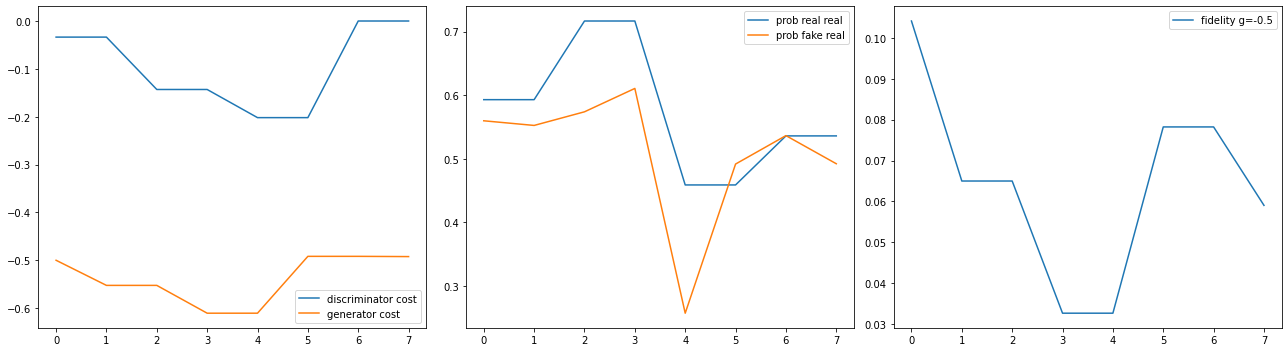

-------------------------------------
----------- TRAINING DONE -----------


In [75]:
snapshot_interval_epochs = 20
results, json_result = trainer.train(disc_weights,
      gen_weights, 
      opt, 
      epochs=epochs, 
      disc_iteration=disc_iteration, 
      gen_iteration=gen_iteration,
      snapshot_interval_epochs=snapshot_interval_epochs)
res_dict = trainer.get_params_and_results()

In [73]:
trained_gen_pairs = res_dict['weights'][-1]['gen_pairs']
trained_disc_pairs = res_dict['weights'][-1]['disc_pairs']

In [25]:
trained_gen_pairs = {
      "theta1": "-3.805953",
      "theta3": "-4.8882213",
      "theta10": "10.795441",
      "theta5": "19.763798",
      "theta0": "1.9086722",
      "theta9": "2.2938647",
      "theta12": "13.140736",
      "theta7": "-10.7745285",
      "theta8": "-13.19596",
      "theta11": "11.439832",
      "theta4": "3.881989",
      "theta6": "-10.842205",
      "theta2": "-4.8848224"
    }

In [26]:
gen_evaluator = CircuitEvaluator(pure_gen, ls, trainer.label_value_provider, trained_gen_pairs, gs)
disc_evaluator = CircuitEvaluator(disc, ls, trainer.label_value_provider, trained_disc_pairs, ds)
real_evaluator = CircuitEvaluator(pure_real, real_symbols, trainer.real_values_provider)

In [27]:
if use_neptune:
    neptune.log_artifact(io.StringIO(disc_evaluator.get_resolved_circuit().to_qasm()), 'desc_qasm.txt')
    neptune.log_artifact(io.StringIO(gen_evaluator.get_resolved_circuit().to_qasm()), 'gen_qasm.txt')
    neptune.log_artifact(io.StringIO(json_result), 'weights.json')

In [28]:
def get_gen_for_g(g, gen_weights, gen_provider):
    rad = gen_provider(g)
    return np.append(gen_weights, rad)

def get_states_and_fidelty_for_real(gen_evaluator, 
                                    real_evaluator, 
                                    gen_pairs, 
                                    g, 
                                    sized):
    generated = gen_evaluator.get_state_from_params()
    real = real_evaluator.get_state_from_params(g)
    return generated, real, cirq.fidelity(generated, real)

def get_states_and_fidelty_for_ground(gen_evaluator, g, gen_weights, size):

    generated = gen_evaluator.get_state_from_params(trace_dims=list(range(size)))
    ground = get_ground_state_for_g(g, size)
    return generated, ground, cirq.fidelity(generated, ground)

def compare_generated_for_g(gen_evaluator, g1, g2, gen_weights, size):
    generated1 = gen_evaluator.get_state_from_params(trace_dims=list(range(size)))
    generated2 = gen_evaluator.get_state_from_params(trace_dims=list(range(size)))
    return generated1, generated2, cirq.fidelity(generated1, generated2)

In [29]:
def angle_dist(g, phase_angles_provider, weights):
    angles = phase_angles_provider(g)
    z1_rad = 3 * math.pi / 2
    z2_rad = -3 * math.pi / 2
    z1_deg = math.degrees(z1_rad)
    z2_deg = math.degrees(z2_rad)
    
    xr_rad = angles[0]
    xv_rad = angles[1]
    xw_rad = angles[2]
    xr_deg = math.degrees(xr_rad)
    xv_deg = math.degrees(xv_rad)
    xw_deg = math.degrees(xw_rad)
    
    
    norm_w_deg = [math.degrees(w) for w in weights]
    deg_diff = [norm_w_deg[0], z1_deg, norm_w_deg[0] - z1_deg, weights[0], z1_rad]
    
    print(z1_deg,z2_deg,xr_deg,xv_deg,xw_deg)
    return deg_diff

In [30]:
g = g_values[0]
generated_state, real_state, fidelity = get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, trained_gen_pairs, g, data_bus_size)

In [31]:
generated_state, real_state, fidelity

(array([ 0.2016527 +0.j, -0.30183655+0.j, -0.18842   +0.j, -0.17124698+0.j,
        -0.11319009+0.j,  0.16942446+0.j, -0.22779992+0.j, -0.20703778+0.j,
        -0.09371056+0.j,  0.14026727+0.j,  0.08756118+0.j,  0.07958066+0.j,
        -0.10826471+0.j,  0.16205211+0.j, -0.2178874 +0.j, -0.19802871+0.j,
        -0.14288682+0.j,  0.21387492+0.j,  0.1335104 +0.j,  0.12134197+0.j,
         0.08020411+0.j, -0.12005059+0.j,  0.16141422+0.j,  0.14670257+0.j,
        -0.13225147+0.j,  0.19795577+0.j,  0.12357295+0.j,  0.11231024+0.j,
        -0.1527914 +0.j,  0.22870027+0.j, -0.3074993 +0.j, -0.27947316+0.j],
       dtype=complex64),
 array([ 0.22222227+0.j,  0.31426978+0.j,  0.22222224+0.j, -0.15713488+0.j,
        -0.1111111 +0.j, -0.15713485+0.j,  0.22222221+0.j, -0.15713486+0.j,
        -0.11111113+0.j, -0.15713489+0.j, -0.11111112+0.j,  0.07856744+0.j,
        -0.11111112+0.j, -0.15713486+0.j,  0.22222224+0.j, -0.15713488+0.j,
        -0.15713489+0.j, -0.22222227+0.j, -0.15713489+0.j,  0.

In [32]:
if use_neptune:
    neptune.log_artifact(io.StringIO(str({"generated_state": generated_state.tolist(), "real_state": real_state.tolist()})), f"states_g={g}.txt")
    neptune.log_metric(f"g={g} fidelity", fidelity)

In [33]:
if use_neptune:
    neptune.stop()

In [34]:
get_g_parameters_provider()(g)

[1.910633236249019, 0.6154797086703875, 2.186276035465284]

In [35]:
real025 = real_evaluator.get_state_from_params(0.25)

In [36]:
real04 = real_evaluator.get_state_from_params(0.4)
real01 = real_evaluator.get_state_from_params(0.1)

In [37]:
cirq.fidelity(real025, -real025)

0.9999996423721633

In [38]:
compare_generated_for_g(gen_evaluator, -0.9, -0.8, trained_gen_weights, data_bus_size)

NameError: name 'trained_gen_weights' is not defined

In [ ]:
g = 0
get_states_and_fidelty_for_ground(gen_evaluator, g, trained_gen_weights, data_bus_size)